In [1]:
import os
from scipy.io import wavfile
import pandas as pd
import numpy as np

Load the .wav files in training data

In [2]:
# Define the root folder containing all subfolders
root_folder = "task1/training"

# Prepare a list to store data
data = []

# Walk through all subfolders and files
for subdir, _, files in os.walk(root_folder):
    for file in files:
        if file.endswith('.wav'):
            filepath = os.path.join(subdir, file)
            sample_rate, audio = wavfile.read(filepath)
            # Store subfolder name for reference
            subfolder = os.path.basename(subdir)
            data.append({
                'filename': file,
                'patient_id': file.split('_')[0],
                'exercise': subfolder,
                'sample_rate': sample_rate,
                'audio': audio
            })

# Create a DataFrame
df = pd.DataFrame(data)

# Show the first few rows
df.head()

,filename,patient_id,exercise,sample_rate,audio
0,ID000_phonationA.wav,ID000,phonationA,8000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,ID001_phonationA.wav,ID001,phonationA,8000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,ID002_phonationA.wav,ID002,phonationA,8000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,ID003_phonationA.wav,ID003,phonationA,8000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,ID005_phonationA.wav,ID005,phonationA,8000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Associate the age, sex and class from .xlsx file

In [3]:
# Load the Excel file with patient info
excel_path = "task1/sand_task_1.xlsx"
patient_info = pd.read_excel(excel_path, usecols=["ID", "Age", "Sex", "Class"], engine="openpyxl")

# Merge patient info into your main DataFrame
df = df.merge(patient_info, left_on="patient_id", right_on="ID", how="left")

# Drop the redundant 'ID' column if desired
df = df.drop(columns=["ID"])

# Show the updated DataFrame
df.head()

,filename,patient_id,exercise,sample_rate,audio,Age,Sex,Class
0,ID000_phonationA.wav,ID000,phonationA,8000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",80,M,5
1,ID001_phonationA.wav,ID001,phonationA,8000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",61,F,5
2,ID002_phonationA.wav,ID002,phonationA,8000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",51,F,4
3,ID003_phonationA.wav,ID003,phonationA,8000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",59,M,3
4,ID005_phonationA.wav,ID005,phonationA,8000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",80,F,5


In [4]:
df.describe()

,sample_rate,Age,Class
count,2176.0,2176.000000,2176.000000
mean,8000.0,63.514706,3.926471
std,0.0,11.258949,1.085799
min,8000.0,23.000000,1.000000
25%,8000.0,56.750000,3.000000
50%,8000.0,64.500000,4.000000
75%,8000.0,72.000000,5.000000
max,8000.0,89.000000,5.000000


Select randomly 20% of patient to exclude and save them in a excluded_patient_ids.txt file

In [5]:
# Select randomly aproximatley 20% of patient to exclude and save their ids in a excluded_patient_ids.txt file
# N.B. The patients to exclude has to be ideally balanced between classes
# Get unique patients and their class
if False:  # Change to True to run again this block (Already executed once)
    patient_classes = df.groupby('patient_id')['Class'].first().reset_index()

    # Calculate number to exclude per class
    frac = 0.2
    to_exclude = (
        patient_classes.groupby('Class', group_keys=False)
        .apply(lambda x: x.sample(frac=frac, random_state=42))
    )

    excluded_patients = to_exclude['patient_id'].values

    # Save to file
    with open('excluded_patient_ids.txt', 'w') as f:
        for patient_id in excluded_patients:
            f.write(f"{patient_id}\n")

    # Exclude patients from the DataFrame
    df = df[~df['patient_id'].isin(excluded_patients)].reset_index(drop=True)
else:
    with open('excluded_patient_ids.txt', 'r') as f:
        excluded_patients = [line.strip() for line in f]

    # Exclude patients from the DataFrame
    df = df[~df['patient_id'].isin(excluded_patients)].reset_index(drop=True)

Data Quality

array([[<Axes: title={'center': 'sample_rate'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'Class'}>, <Axes: >]], dtype=object)

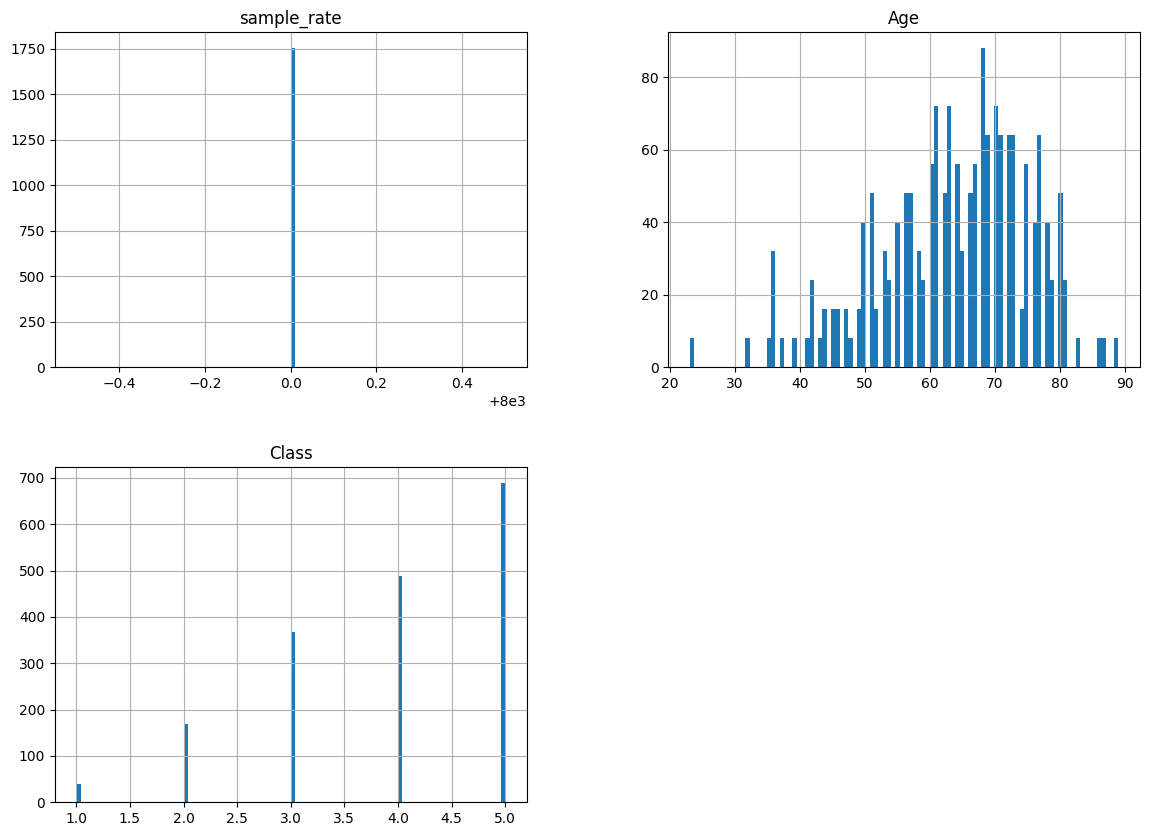

In [6]:
df.hist(bins=100, figsize=(14, 10))
# Great! no particular outliers

Check if all classes are equally represented in all exercises

<Axes: xlabel='exercise'>

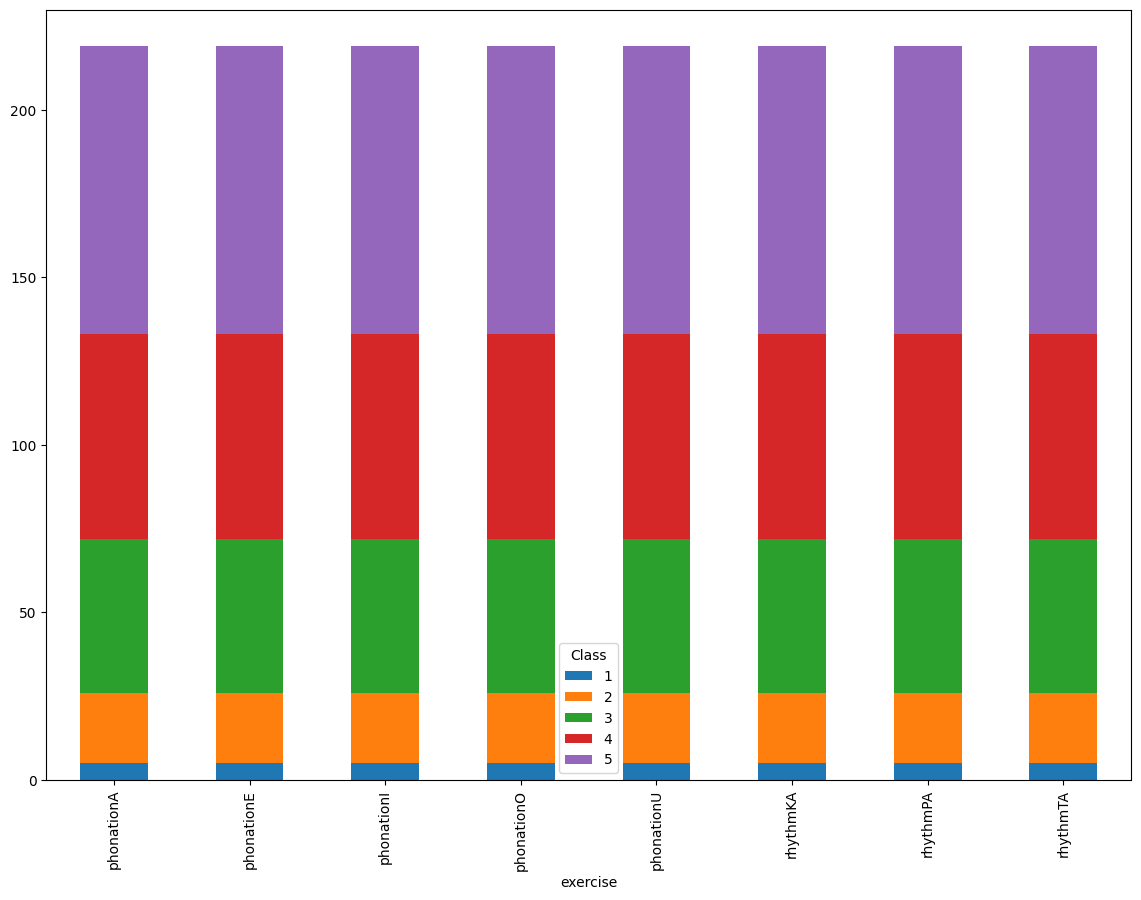

In [7]:
# check class distribution over exercises
class_distribution = df.groupby(['exercise', 'Class']).size().unstack(fill_value=0)
class_distribution.plot(kind='bar', stacked=True, figsize=(14, 10))

Influence of Sex

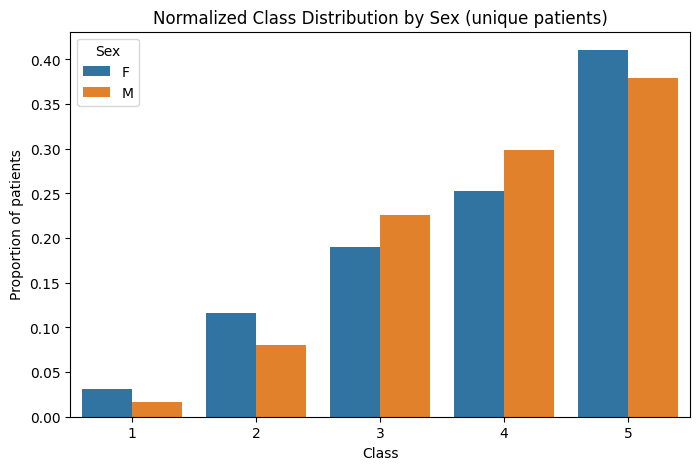

In [8]:
# Group by patient_id and Sex, take the first Class value for each patient
patient_classes = df.groupby(['patient_id', 'Sex'])['Class'].first().reset_index()

# Calculate normalized value counts for each Sex
class_dist = (
    patient_classes.groupby('Sex')['Class']
    .value_counts(normalize=True)
    .rename('proportion')
    .reset_index()
)

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.barplot(data=class_dist, x='Class', y='proportion', hue='Sex')
plt.title('Normalized Class Distribution by Sex (unique patients)')
plt.ylabel('Proportion of patients')
plt.show()

# MAle and female seems to have different distribution of classes!

Influence of Age

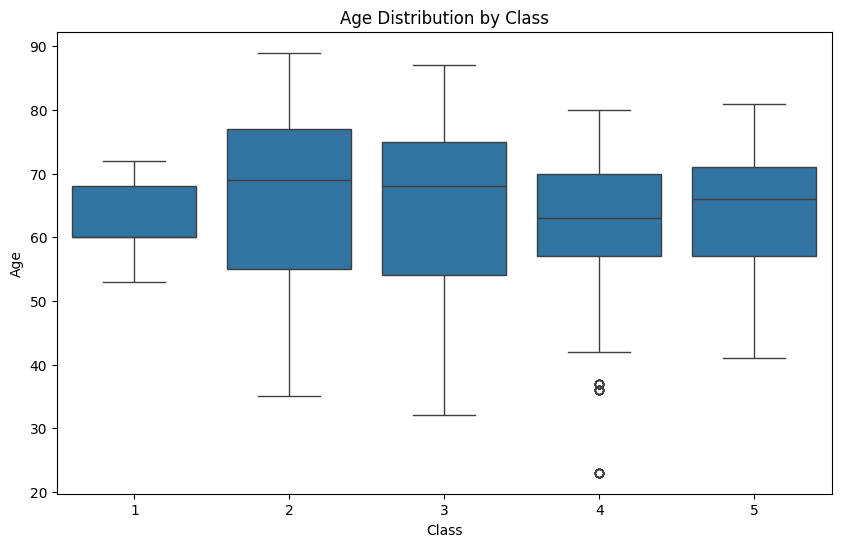

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Class", y="Age")
plt.title("Age Distribution by Class")
plt.show()

# The age distribution does not seem to have a strong correlation with the classs

Influence of audio length

In [10]:
# Inspect the variability of audio lengths
df['audio_length'] = df['audio'].apply(len) / df['sample_rate']
df['audio_length'].describe()

count    1752.000000
mean       13.711151
std         7.281372
min         0.720000
25%         8.340000
50%        12.280000
75%        17.840000
max        48.240000
Name: audio_length, dtype: float64

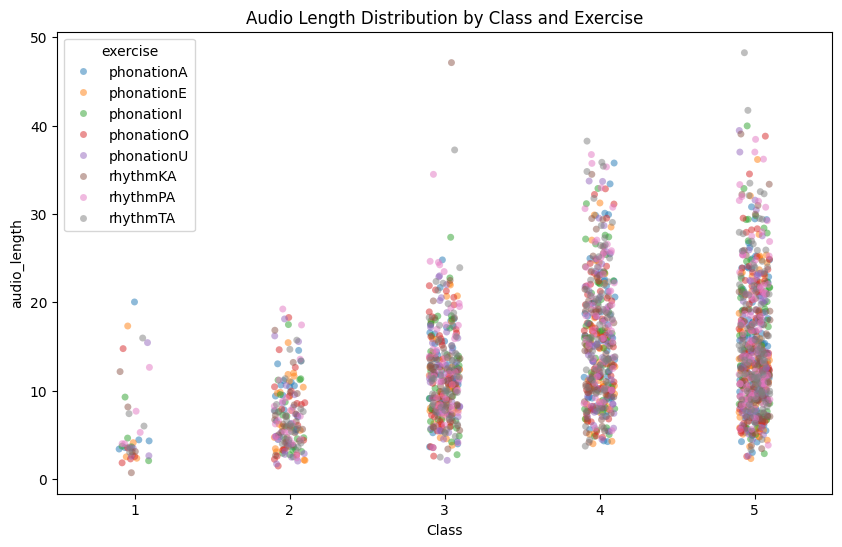

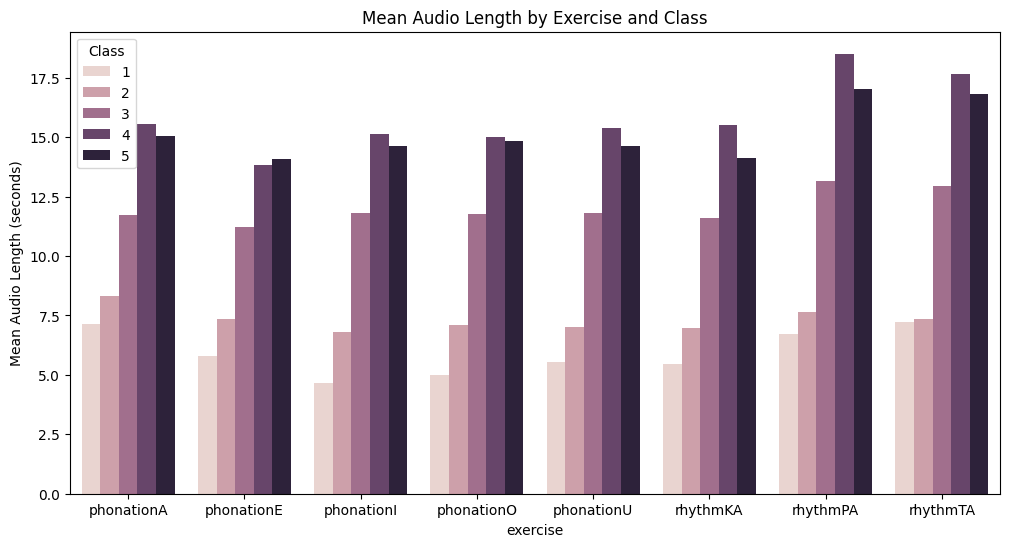

In [11]:
# Let's see if the length of the audio is correlated with the class, coloring points by exercise
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.stripplot(data=df, x="Class", y="audio_length", hue="exercise", jitter=True, alpha=0.5)
plt.title("Audio Length Distribution by Class and Exercise")
plt.show()

# Plot the mean duration by exercise and class
mean_durations = df.groupby(['exercise', 'Class'])['audio_length'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=mean_durations, x='exercise', y='audio_length', hue='Class')
plt.title('Mean Audio Length by Exercise and Class')
plt.ylabel('Mean Audio Length (seconds)')
plt.show()

# There is a clear correlation between audio length and class!

Influence of audio amplitude (volume)

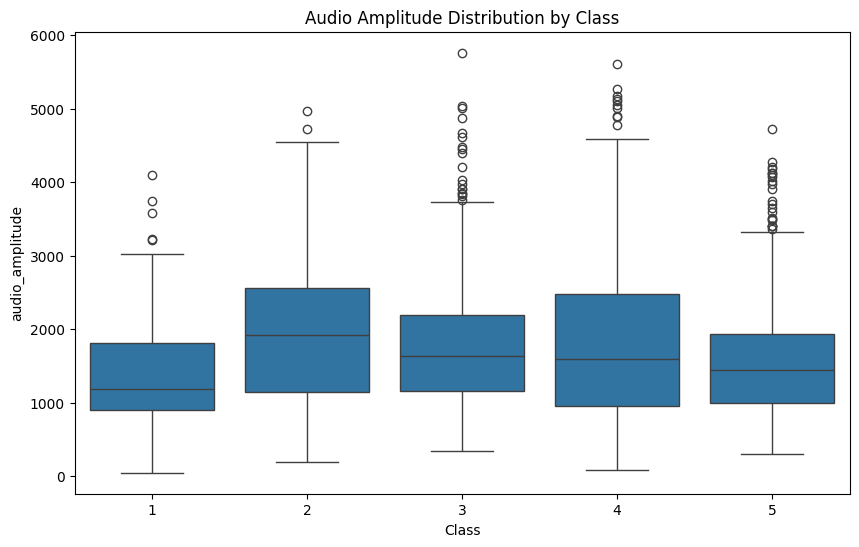

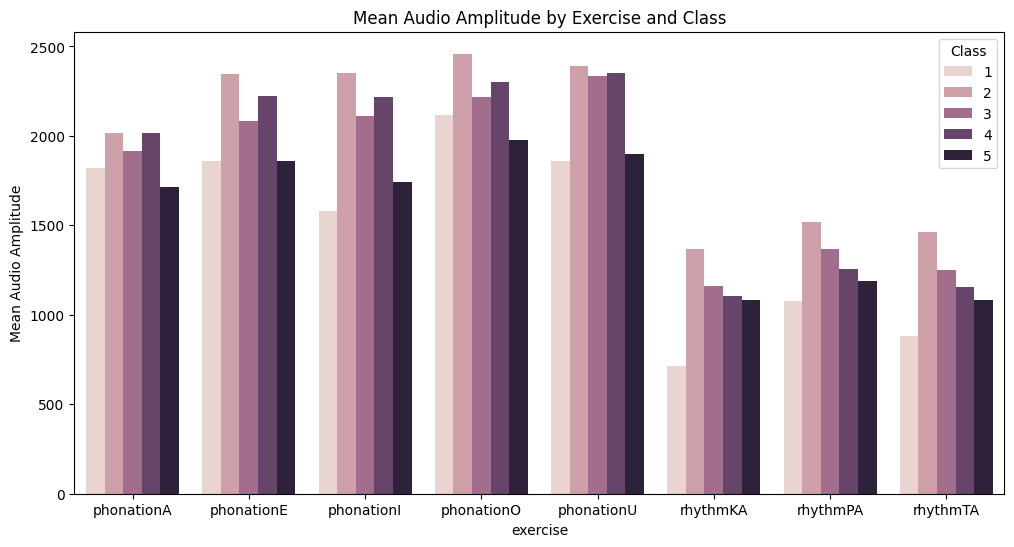

In [12]:
# Let us see if the audio amplitude (volume) is correlated with the class
df['audio_amplitude'] = df['audio'].apply(lambda x: np.mean(np.abs(x)))
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Class", y="audio_amplitude")
plt.title("Audio Amplitude Distribution by Class")
plt.show()

# Plot the mean amplitude by exercise and class
mean_amplitudes = df.groupby(['exercise', 'Class'])['audio_amplitude'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=mean_amplitudes, x='exercise', y='audio_amplitude', hue='Class')
plt.title('Mean Audio Amplitude by Exercise and Class')
plt.ylabel('Mean Audio Amplitude')
plt.show()

# The amplitude distribution is wide, but there is a slight correlation with the class

Try a minimal Decision Tree Classifier

              precision    recall  f1-score   support

           0      0.400     0.750     0.522         8
           1      0.215     0.424     0.286        33
           2      0.307     0.311     0.309        74
           3      0.426     0.469     0.447        98
           4      0.534     0.341     0.416       138

    accuracy                          0.387       351
   macro avg      0.376     0.459     0.396       351
weighted avg      0.423     0.387     0.392       351



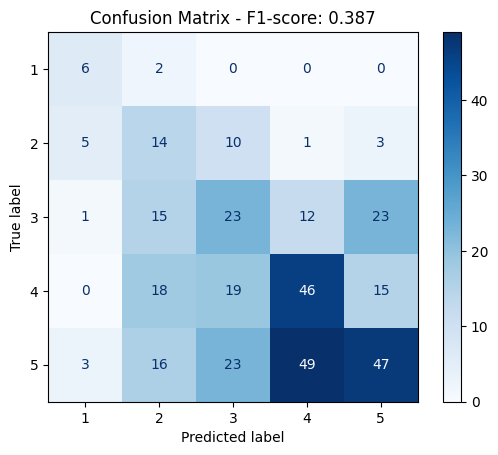

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Prepare features
df_simple = df[['exercise', 'Age', 'Sex', 'audio_length', 'audio_amplitude', 'Class']].dropna()

# Encode categorical variables
df_simple['exercise'] = LabelEncoder().fit_transform(df_simple['exercise'])
df_simple['Sex'] = LabelEncoder().fit_transform(df_simple['Sex'])

X = df_simple[['exercise', 'Age', 'Sex', 'audio_length', 'audio_amplitude']]
y = df_simple['Class'] - 1  # Classes 0-4 for sklearn

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train
clf = DecisionTreeClassifier(random_state=42, max_depth=5, class_weight='balanced')
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

# Plot a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=[1, 2, 3, 4, 5], cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix - F1-score: {clf.score(X_test, y_test):.3f}")
plt.show()

# Pretty bad results, but this is a very simple model based on few features

Let us build a np matrix, handly for Fourier analysis

We will consider only rhythm exercises

In [14]:
exercise_list = []
for ex in df['exercise'].unique():
    if 'rhythm' in ex.lower():  # Select only rhythm exercises
        exercise_list.append(ex)
n_pz = df['patient_id'].nunique()
n_ex = len(exercise_list)
n_cl = df['Class'].nunique()
max_t = 15*df['sample_rate'].min()  # 15 seconds at the minimum sample rate

print(f"Number of unique patients: {n_pz}")
print(f"Number of unique exercises: {n_ex}")
print(f"Number of unique classes: {n_cl}")
print(f"Maximum audio length (in samples): {max_t}")

Number of unique patients: 219
Number of unique exercises: 3
Number of unique classes: 5
Maximum audio length (in samples): 120000


In [15]:
df_rhythm = df[df['exercise'].isin(exercise_list)].reset_index(drop=True)

data_matrix = np.zeros((n_pz, n_ex, max_t))
patient_id_to_index = {pid: idx for idx, pid in enumerate(df_rhythm['patient_id'].unique())}
exercise_to_index = {ex: idx for idx, ex in enumerate(exercise_list)}
class_to_patient = {pid: cls for pid, cls in zip(df_rhythm['patient_id'], df_rhythm['Class'])}
for _, row in df_rhythm.iterrows():
    pid_idx = patient_id_to_index[row['patient_id']]
    ex_idx = exercise_to_index[row['exercise']]
    class_label = row['Class']
    audio = np.array(row['audio'])
    end = min(len(audio), max_t)
    data_matrix[pid_idx, ex_idx, :end] = audio[0:end]

data_matrix.shape

(219, 3, 120000)

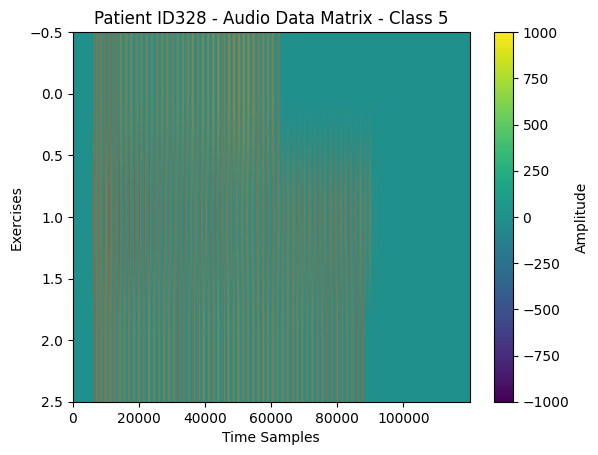

In [16]:
# Let's visualize the matrix, checking for zero values
import matplotlib.pyplot as plt

index = np.random.randint(0, n_pz)  # Random patient index
index = 210
plt.imshow(data_matrix[index, :, :], aspect='auto', cmap='viridis', vmin=-1000, vmax=1000)
plt.colorbar(label='Amplitude')
plt.title(f'Patient {df["patient_id"].unique()[index]} - Audio Data Matrix - Class {class_to_patient[df["patient_id"].unique()[index]]}')
plt.xlabel('Time Samples')
plt.ylabel('Exercises')
plt.show()

Augment data with window slicing:

slice window: 0.6 of max audio length
augmentation factor: 10 for each sample

In [17]:
def window_slice(x, reduce_ratio=0.6):
    target_len = int(reduce_ratio * x.shape[-1])  # Target length along time dimension
    if target_len >= x.shape[-1]:
        return x
    starts = np.random.randint(low=0, high=x.shape[-1] - target_len, size=1)
    ends = (target_len + starts).astype(int)

    # Create slicing object to select all elements along all dimensions except the last
    slicer = [slice(None)] * (x.ndim - 1)

    # Add the slice for the time dimension
    slicer.append(slice(starts[0], ends[0]))

    # Apply the slicing object to the array
    sliced_x = x[tuple(slicer)]
    # The mapping of rows remains the same as the original indices
    row_indices = np.arange(x.shape[0])
    return sliced_x, row_indices

In [18]:
reducing_time_factor = 0.6
augmentation_factor = 10

augmented_data_list = []
augmented_indices_list = []

for i in range(augmentation_factor):
    sliced_data, row_indices = window_slice(data_matrix, reduce_ratio=reducing_time_factor)
    augmented_data_list.append(sliced_data)
    augmented_indices_list.append(row_indices)

augmented_data = np.concatenate(augmented_data_list)
augmented_indices = np.concatenate(augmented_indices_list)
print(augmented_data.shape, augmented_indices.shape)

(2190, 3, 72000) (2190,)


In [19]:
# Save the new class labels for the augmented data

# First, build a reverse mapping from index to patient_id
index_to_patient_id = {v: k for k, v in patient_id_to_index.items()}

# Now, build the class array for augmented_data
class_array = np.array([
    class_to_patient[index_to_patient_id[idx]]
    for idx in augmented_indices
])
class_array.shape

(2190,)

Smooth higer frequencies (we need the lower ones for detecting repetintion in rhythm)

In [20]:
from scipy.signal import butter, lfilter

def butter_lowpass(cutoff, fs, order=5):
  nyq = 0.5 * fs
  normal_cutoff = cutoff / nyq
  b, a = butter(order, normal_cutoff, btype='low', analog=False)
  return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
  b, a = butter_lowpass(cutoff, fs, order=order)
  y = lfilter(b, a, data)
  return y

In [21]:
cutoff = 2000  # desired cutoff frequency of the filter, Hz
fs = df['sample_rate'].iloc[0]  # sample rate, Hz
order = 4

for pz in np.arange(n_pz):
    for ex in np.arange(n_ex):
        if not np.isnan(augmented_data[pz, ex, :]).all():
            augmented_data[pz, ex, :] = butter_lowpass_filter(augmented_data[pz, ex, :], cutoff=cutoff, fs=fs, order=order)

Fourier Analysis

In [22]:
# Select randomly 1000 samples from augmented_data
# n_rand = 1000
# rand_indices = np.random.choice(augmented_data.shape[0], n_rand, replace=False)
# rand_data = augmented_data[rand_indices, :, :]
# labels = class_array[rand_indices]
labels = class_array
fft_data = np.abs(np.fft.rfft(augmented_data, axis=-1))
fft_data.shape

(2190, 3, 36001)

In [23]:
freq = np.fft.rfftfreq(augmented_data.shape[-1], d=1/df['sample_rate'].iloc[0])
freq.shape

(36001,)

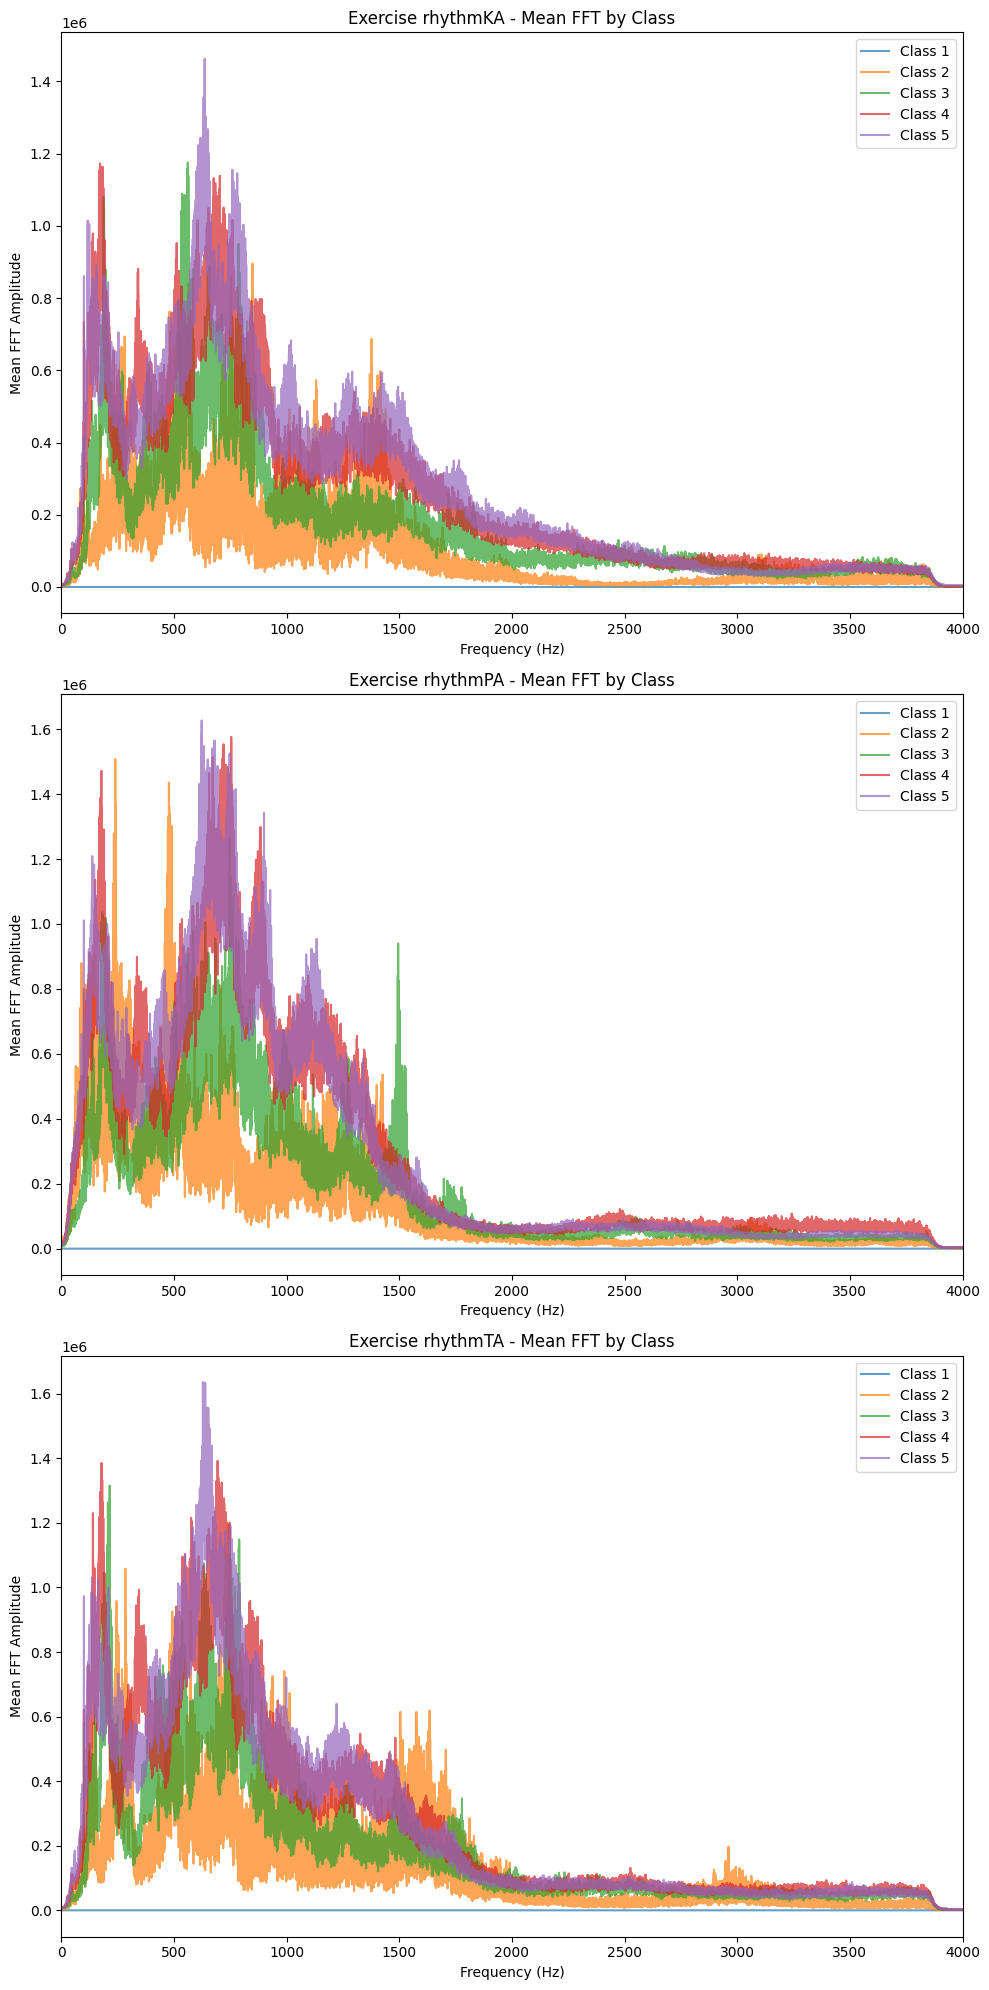

In [24]:
# Compute the mean fft across patients for each class and exercise
mean_fft = np.zeros((n_ex, n_cl, fft_data.shape[-1]))
for ex in range(n_ex):
    for cl in range(n_cl):
        class_mask = (labels == cl)
        if np.any(class_mask):
            mean_fft[ex, cl, :] = np.mean(fft_data[class_mask, ex, :], axis=0)

# Reverse the exercise_to_index dictionary
index_to_exercise = {v: k for k, v in exercise_to_index.items()}

# plot mean_fft for each exercise and colored by class
plt.figure(figsize=(10, 20))
for ex in range(n_ex):
    plt.subplot(n_ex, 1, ex + 1)
    for cl in range(n_cl):
        if cl in [0, 1, 2, 3, 4]:  # Plot only classes 0 and 1
            plt.plot(freq, mean_fft[ex, cl, :], label=f'Class {cl+1}', alpha=0.7)
    plt.title(f'Exercise {index_to_exercise[ex]} - Mean FFT by Class')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Mean FFT Amplitude')
    plt.legend(loc='upper right')
    plt.xlim(0, 4000)
    # plt.ylim(0, np.max(mean_fft) * 1.1)
plt.tight_layout()
plt.show()
    
    


Meaningfull differences appear only for frequencies lower than 2000Hz, so for reducing the dimensionality let us cut the fft

In [25]:
f_max = 2000
f_mask = freq <= f_max

fft_data_reduced = fft_data[:, :, f_mask]
fft_data_reduced.shape

(2190, 3, 18001)

Now interpolate the fft for further reducing the dimensionality

In [26]:
# Use a second interpolation to reduce the dimensionality further
from scipy.interpolate import interp1d

smooth_dim = 200
fft_smooth = np.zeros((fft_data_reduced.shape[0], fft_data_reduced.shape[1], smooth_dim))
for i in range(fft_data_reduced.shape[0]):
    for j in range(fft_data_reduced.shape[1]):
        f = interp1d(freq[f_mask], fft_data_reduced[i, j, :], kind='quadratic', fill_value="extrapolate")
        fft_smooth[i, j, :] = f(np.linspace(0, f_max, smooth_dim))

# Get the new frequency axis after interpolation
freq_smooth = np.linspace(0, f_max, smooth_dim)

fft_smooth.shape

(2190, 3, 200)

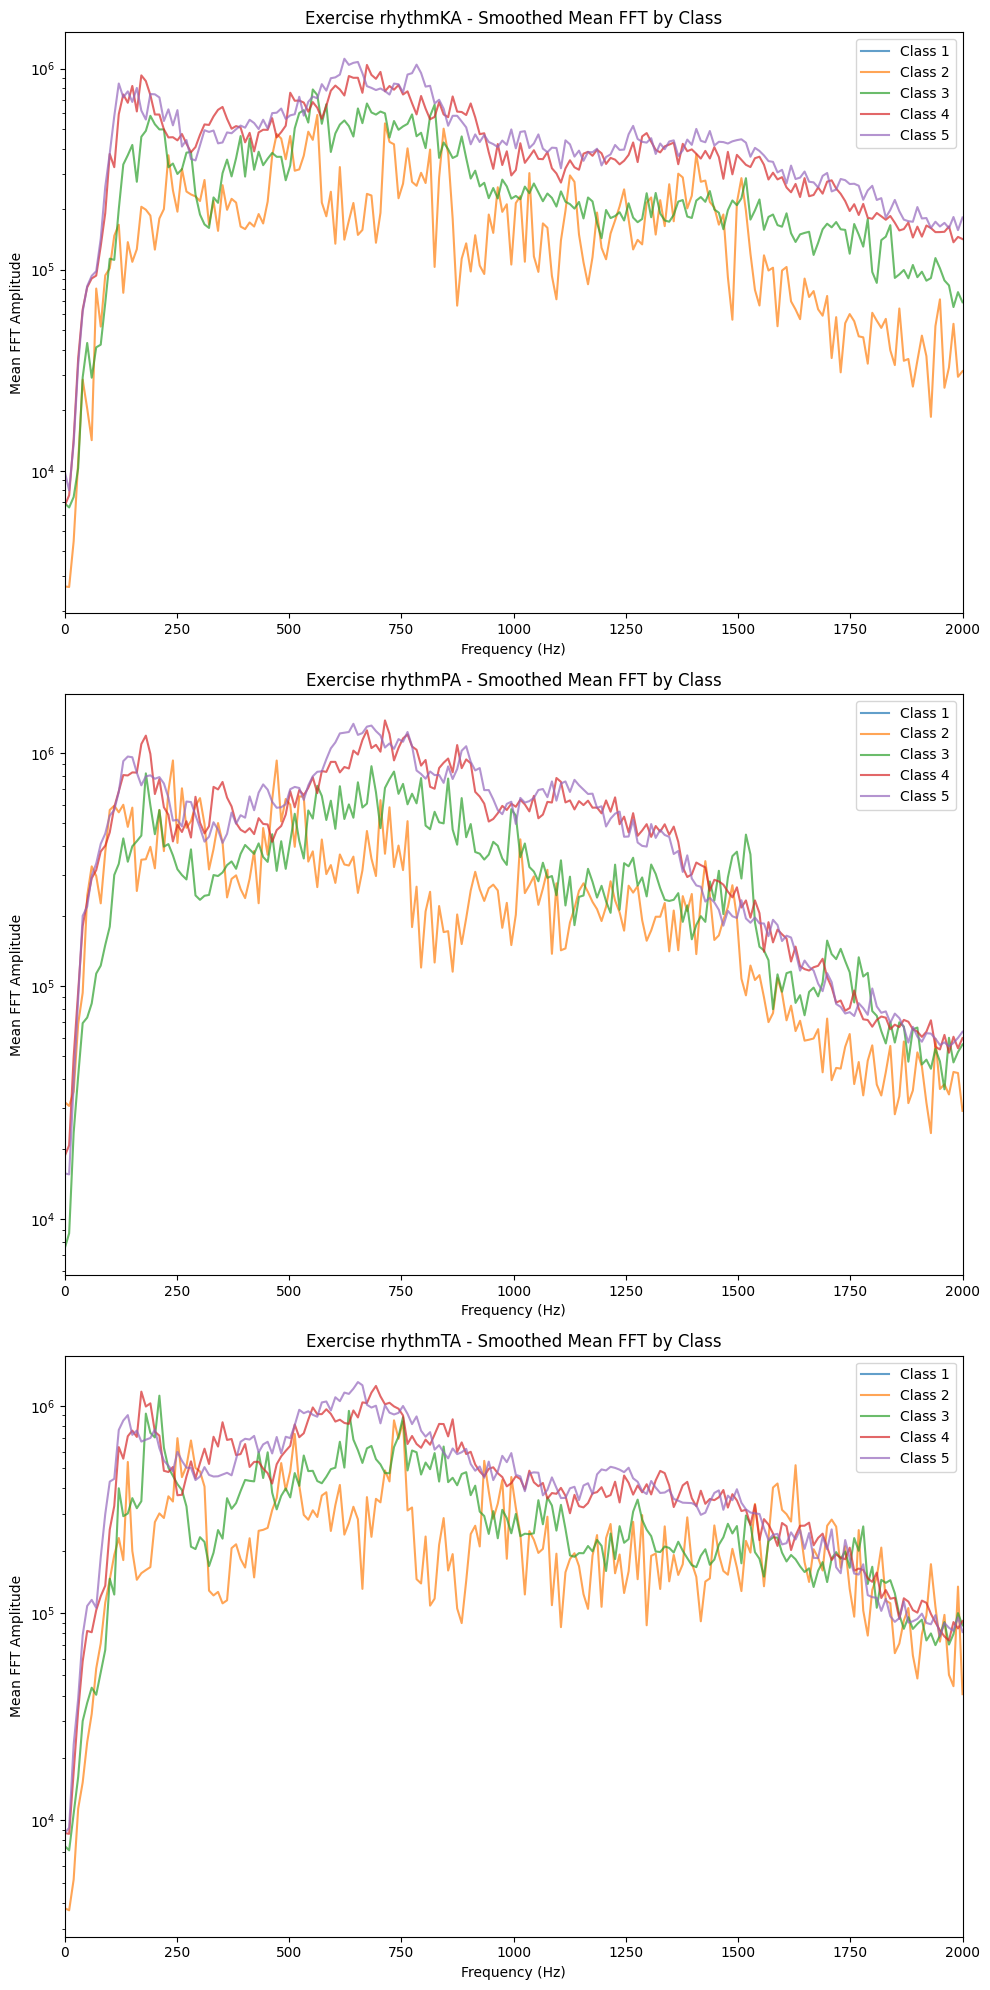

In [27]:
fft_smooth_mean = np.zeros((n_ex, n_cl, fft_smooth.shape[-1]))
for ex in range(n_ex):
    for cl in range(n_cl):
        class_mask = (labels == cl)
        if np.any(class_mask):
            fft_smooth_mean[ex, cl, :] = np.nanmean(fft_smooth[class_mask, ex, :], axis=0)

# plot fft_smooth_mean for each exercise and colored by class
plt.figure(figsize=(10, 20))
for ex in range(n_ex):
    plt.subplot(n_ex, 1, ex + 1)
    for cl in range(n_cl):
        plt.semilogy(freq_smooth, fft_smooth_mean[ex, cl, :], label=f'Class {cl+1}', alpha=0.7)
    plt.title(f'Exercise {index_to_exercise[ex]} - Smoothed Mean FFT by Class')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Mean FFT Amplitude')
    plt.legend(loc='upper right')
    plt.xlim(0, f_max)
    # plt.ylim(0, np.max(fft_smooth_mean) * 0.8)
plt.tight_layout()
plt.show()

Let us train a quick NN

In [28]:
fft_smooth.shape

(2190, 3, 200)

In [29]:
labels.shape

(2190,)

In [30]:
from sklearn.preprocessing import StandardScaler
import joblib

X = fft_smooth.reshape(fft_smooth.shape[0]*n_ex, smooth_dim)
scaler = StandardScaler()
X = scaler.fit_transform(X)
joblib.dump(scaler, "models/X_rhythm_scaler.pkl")
y = np.zeros((labels.shape[0], n_ex, n_cl))
for i in range(labels.shape[0]):
    for ex in range(n_ex):
        y[i, ex, labels[i]-1] = 1

y = y.reshape(y.shape[0]*n_ex, n_cl)
    

In [ ]:
save = False

if save:
    np.save("input_output/X_rhythm.npy", X)
    np.save("input_output/y_rhythm.npy", y)

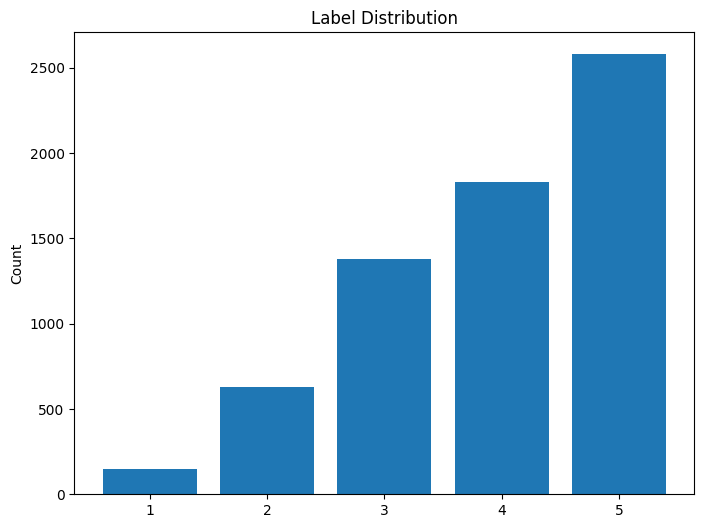

In [34]:
# Check label distribution
plt.figure(figsize=(8, 6))
plt.bar(range(1, y.shape[1] + 1), np.sum(y, axis=0))
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()

In [35]:
from sklearn.utils.class_weight import compute_class_weight

# Use all possible class indices for one-hot encoded y
class_weights = compute_class_weight('balanced', classes=np.arange(y.shape[1]), y=y.argmax(axis=1))

# format as a dict class: weight
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(8.76), 1: np.float64(2.085714285714286), 2: np.float64(0.9521739130434783), 3: np.float64(0.7180327868852459), 4: np.float64(0.5093023255813953)}


In [36]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y.argmax(axis=1))


In [37]:
import tensorflow as tf

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,    #0.05               best with 0.001
  decay_steps=50, #100        best with 100
  decay_rate=4, #1              best with 1
  staircase=True)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

def get_callbacks(name):
    return [
        tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=200, min_delta=0.001),
        ]

def compile_and_fit(model, name, x_train, y_train, x_test, y_test, optimizer=None, max_epochs=100):

    if optimizer is None:
        optimizer = get_optimizer()

    model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    model.summary()

    history = model.fit(
            x_train, y_train,
            epochs=max_epochs,
            # batch_size=500,
            validation_data=(x_test, y_test),
            callbacks=get_callbacks(name),
            class_weight=class_weights,
            verbose=2)

    return history

c:\Users\adriano.minora\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       102,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 275,717 (1.05 MB)

 Trainable params: 275,717 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2000
165/165 - 3s - 21ms/step - accuracy: 0.4623 - loss: 2.0495 - val_accuracy: 0.5898 - val_loss: 1.8885
Epoch 2/2000
165/165 - 1s - 5ms/step - accuracy: 0.6220 - loss: 1.7337 - val_accuracy: 0.6164 - val_loss: 1.8114
Epoch 3/2000
165/165 - 1s - 5ms/step - accuracy: 0.6566 - loss: 1.6403 - val_accuracy: 0.6362 - val_loss: 1.7470
Epoch 4/2000
165/165 - 1s - 6ms/step - accuracy: 0.6724 - loss: 1.5917 - val_accuracy: 0.6804 - val_loss: 1.6693
Epoch 5/2000
165/165 - 1s - 7ms/step - accuracy: 0.6916 - loss: 1.5616 - val_accuracy: 0.6766 - val_loss: 1.6537
Epoch 6/2000
165/165 - 1s - 4ms/step - accuracy: 0.6960 - loss: 1.5291 - val_accuracy: 0.6811 - val_loss: 1.6373
Epoch 7/2000
165/165 - 1s - 6ms/step - accuracy: 0.7095 - loss: 1.5135 - val_accuracy: 0.6872 - val_loss: 1.6214
Epoch 8/2000
165/165 - 1s - 5ms/step - accuracy: 0.7205 - loss: 1.4853 - val_accuracy: 0.6895 - val_loss: 1.5993
Epoch 9/2000
165/165 - 1s - 6ms/step - accuracy: 0.7314 - loss: 1.4758 - val_accuracy: 0.6910 -

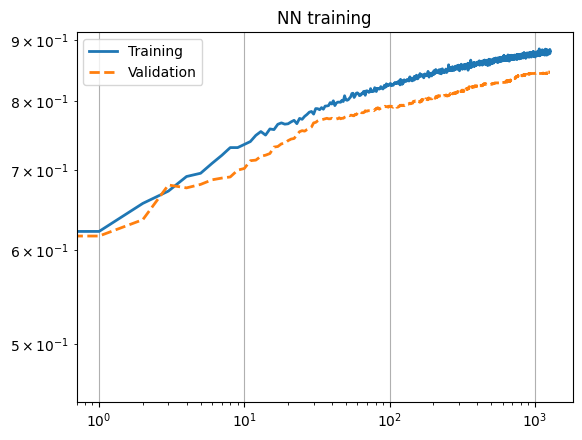

In [38]:
from tensorflow.keras import layers, regularizers

INPUTDIM = X_train.shape[1]
OUTPUTDIM = y_train.shape[1]

n_train=X_train.shape[0]
n_val=X_val.shape[0]

dropout= 0.01
reg = 0.001

NN = tf.keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=(INPUTDIM,),kernel_regularizer = regularizers.l2(reg)),
    layers.Dropout(dropout),
    layers.Dense(256, activation='relu', kernel_regularizer = regularizers.l2(reg)),
    layers.Dropout(dropout),
    layers.Dense(128, activation='relu', kernel_regularizer = regularizers.l2(reg)),
    layers.Dropout(dropout),
    layers.Dense(64, activation='relu', kernel_regularizer = regularizers.l2(reg)),
    layers.Dropout(dropout),
    layers.Dense(OUTPUTDIM, activation='softmax')
])

history = compile_and_fit(NN, 'NN',X_train, y_train, X_val, y_val, max_epochs=2000)

bc     = history.history['accuracy']
val_bc = history.history['val_accuracy']

plt.loglog(range(np.shape(bc)[0]),bc, linewidth=2,)
plt.loglog(range(np.shape(val_bc)[0]),val_bc,'--', linewidth=2,)
plt.title('NN training')
plt.grid(True)
#plt.show(block=False)

plt.legend(('Training','Validation'))
plt.show()

# Alittle bit of overfitting, but as a first try look promising

Epoch 1273/2000
165/165 - 1s - 5ms/step - accuracy: 0.8790 - loss: 1.0665 - val_accuracy: 0.8463 - val_loss: 1.1511

206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
F1 score: 0.7936438244829508


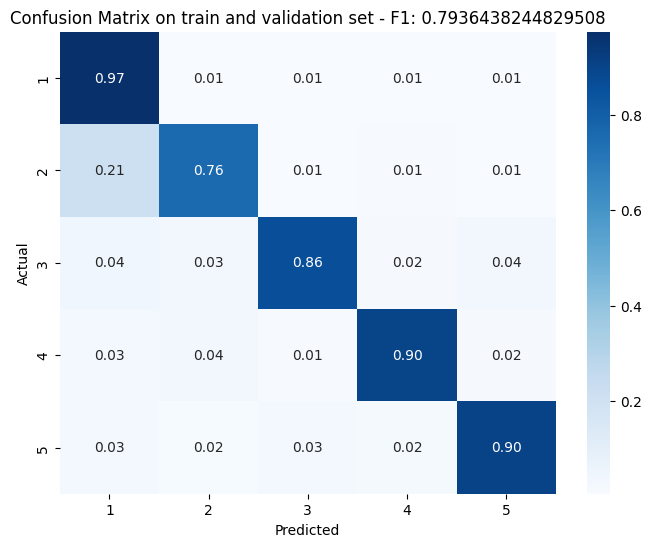

In [39]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

# Example true labels and predicted labels
y_true = np.argmax(np.concatenate((y_val, y_train)), axis=-1)
y_pred = np.argmax(NN.predict(np.concatenate((X_val, X_train))), axis=-1)

# Compute the f1 score
f1 = f1_score(y_true, y_pred, average='macro')
print('F1 score:', f1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(n_cl), normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(1,n_cl+1), yticklabels=range(1,n_cl+1))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix on train and validation set - F1: {f1}')
plt.show()

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
F1 score: 0.7525949714388791


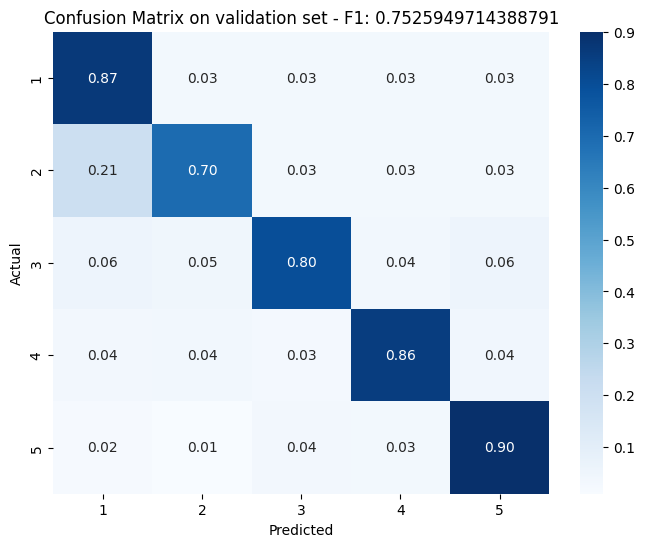

In [40]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

# Example true labels and predicted labels
y_true = np.argmax(y_val, axis=-1)
y_pred = np.argmax(NN.predict(X_val), axis=-1)

# Compute the f1 score
f1 = f1_score(y_true, y_pred, average='macro')
print('F1 score:', f1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(n_cl), normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(1,n_cl+1), yticklabels=range(1,n_cl+1))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix on validation set - F1: {f1}')
plt.show()

In [60]:
# Save the NN

save = False
if save:
    NN.save('models/NN_rhythm_categorical_1_5.keras')
    print("Model saved.")
else:
    print("Model not saved.")

Model not saved.


Do the same preprocessing, but divided in Male and Female

In [43]:
# Create two new dataframe for male and female patients

# Male patients
df_m = df[df['Sex'] == 'M'].copy()
# Female patients
df_f = df[df['Sex'] == 'F'].copy()

In [44]:
exercise_list = []
for ex in df['exercise'].unique():
    if 'rhythm' in ex.lower():  # Select only rhythm exercises
        exercise_list.append(ex)
n_pz_m = df_m['patient_id'].nunique()
n_pz_f = df_f['patient_id'].nunique()
n_ex = len(exercise_list)
n_cl = df['Class'].nunique()
max_t = 15*df['sample_rate'].min()  # 15 seconds at the minimum sample rate

print(f"Number of unique male patients: {n_pz_m}")
print(f"Number of unique female patients: {n_pz_f}")
print(f"Number of unique exercises: {n_ex}")
print(f"Number of unique classes: {n_cl}")
print(f"Maximum audio length (in samples): {max_t}")

Number of unique male patients: 124
Number of unique female patients: 95
Number of unique exercises: 3
Number of unique classes: 5
Maximum audio length (in samples): 120000


In [45]:
df_rhythm_m = df_m[df_m['exercise'].isin(exercise_list)].reset_index(drop=True)
df_rhythm_f = df_f[df_f['exercise'].isin(exercise_list)].reset_index(drop=True)
exercise_to_index = {ex: idx for idx, ex in enumerate(exercise_list)}

In [46]:
data_matrix_m = np.zeros((n_pz_m, n_ex, max_t))
patient_id_to_index_m = {pid: idx for idx, pid in enumerate(df_rhythm_m['patient_id'].unique())}
class_to_patient_m = {pid: cls for pid, cls in zip(df_rhythm_m['patient_id'], df_rhythm_m['Class'])}
for _, row in df_rhythm_m.iterrows():
    pid_idx = patient_id_to_index_m[row['patient_id']]
    ex_idx = exercise_to_index[row['exercise']]
    class_label = row['Class']
    audio = np.array(row['audio'])
    end = min(len(audio), max_t)
    data_matrix_m[pid_idx, ex_idx, :end] = audio[0:end]

data_matrix_m.shape

(124, 3, 120000)

In [47]:
data_matrix_f = np.zeros((n_pz_f, n_ex, max_t))
patient_id_to_index_f = {pid: idx for idx, pid in enumerate(df_rhythm_f['patient_id'].unique())}
class_to_patient_f = {pid: cls for pid, cls in zip(df_rhythm_f['patient_id'], df_rhythm_f['Class'])}
for _, row in df_rhythm_f.iterrows():
    pid_idx = patient_id_to_index_f[row['patient_id']]
    ex_idx = exercise_to_index[row['exercise']]
    class_label = row['Class']
    audio = np.array(row['audio'])
    end = min(len(audio), max_t)
    data_matrix_f[pid_idx, ex_idx, :end] = audio[0:end]

data_matrix_f.shape

(95, 3, 120000)

In [48]:
def window_slice(x, reduce_ratio=0.6):
    target_len = int(reduce_ratio * x.shape[-1])  # Target length along time dimension
    if target_len >= x.shape[-1]:
        return x
    starts = np.random.randint(low=0, high=x.shape[-1] - target_len, size=1)
    ends = (target_len + starts).astype(int)

    # Create slicing object to select all elements along all dimensions except the last
    slicer = [slice(None)] * (x.ndim - 1)

    # Add the slice for the time dimension
    slicer.append(slice(starts[0], ends[0]))

    # Apply the slicing object to the array
    sliced_x = x[tuple(slicer)]
    # The mapping of rows remains the same as the original indices
    row_indices = np.arange(x.shape[0])
    return sliced_x, row_indices

In [49]:
reducing_time_factor = 0.6
augmentation_factor = 10

augmented_data_list_m = []
augmented_data_list_f = []
augmented_indices_list_m = []
augmented_indices_list_f = []

for i in range(augmentation_factor):
    sliced_data_m, row_indices_m = window_slice(data_matrix_m, reduce_ratio=reducing_time_factor)
    sliced_data_f, row_indices_f = window_slice(data_matrix_f, reduce_ratio=reducing_time_factor)
    augmented_data_list_m.append(sliced_data_m)
    augmented_data_list_f.append(sliced_data_f)
    augmented_indices_list_m.append(row_indices_m)
    augmented_indices_list_f.append(row_indices_f)

augmented_data_m = np.concatenate(augmented_data_list_m)
augmented_data_f = np.concatenate(augmented_data_list_f)
augmented_indices_m = np.concatenate(augmented_indices_list_m)
augmented_indices_f = np.concatenate(augmented_indices_list_f)
print(augmented_data_m.shape, augmented_indices_m.shape, augmented_data_f.shape, augmented_indices_f.shape)

(1240, 3, 72000) (1240,) (950, 3, 72000) (950,)


In [50]:
# Save the new class labels for the augmented data

# First, build a reverse mapping from index to patient_id
index_to_patient_id_m = {v: k for k, v in patient_id_to_index_m.items()}
index_to_patient_id_f = {v: k for k, v in patient_id_to_index_f.items()}

# Now, build the class array for augmented_data
class_array_m = np.array([
    class_to_patient_m[index_to_patient_id_m[idx]]
    for idx in augmented_indices_m
])
print(class_array_m.shape)
class_array_f = np.array([
    class_to_patient_f[index_to_patient_id_f[idx]]
    for idx in augmented_indices_f
])
print(class_array_f.shape)

(1240,)
(950,)


In [51]:
from scipy.signal import butter, lfilter

def butter_lowpass(cutoff, fs, order=5):
  nyq = 0.5 * fs
  normal_cutoff = cutoff / nyq
  b, a = butter(order, normal_cutoff, btype='low', analog=False)
  return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
  b, a = butter_lowpass(cutoff, fs, order=order)
  y = lfilter(b, a, data)
  return y

In [52]:
cutoff = 2000  # desired cutoff frequency of the filter, Hz
fs = df['sample_rate'].iloc[0]  # sample rate, Hz
order = 4

for pz in np.arange(n_pz_m):
    for ex in np.arange(n_ex):
        if not np.isnan(augmented_data_m[pz, ex, :]).all():
            augmented_data_m[pz, ex, :] = butter_lowpass_filter(augmented_data_m[pz, ex, :], cutoff=cutoff, fs=fs, order=order)

for pz in np.arange(n_pz_f):
    for ex in np.arange(n_ex):
        if not np.isnan(augmented_data_f[pz, ex, :]).all():
            augmented_data_f[pz, ex, :] = butter_lowpass_filter(augmented_data_f[pz, ex, :], cutoff=cutoff, fs=fs, order=order)

In [53]:
labels_m = class_array_m
labels_f = class_array_f
fft_data_m = np.abs(np.fft.rfft(augmented_data_m, axis=-1))
fft_data_f = np.abs(np.fft.rfft(augmented_data_f, axis=-1))
fft_data_m.shape, fft_data_f.shape

((1240, 3, 36001), (950, 3, 36001))

In [54]:
freq_m = np.fft.rfftfreq(augmented_data_m.shape[-1], d=1/df['sample_rate'].iloc[0])
freq_f = np.fft.rfftfreq(augmented_data_f.shape[-1], d=1/df['sample_rate'].iloc[0])
freq_m.shape, freq_f.shape

((36001,), (36001,))

In [55]:
f_max = 2000
f_mask_m = freq_m <= f_max
f_mask_f = freq_f <= f_max

fft_data_reduced_m = fft_data_m[:, :, f_mask_m]
fft_data_reduced_f = fft_data_f[:, :, f_mask_f]
fft_data_reduced_m.shape, fft_data_reduced_f.shape

((1240, 3, 18001), (950, 3, 18001))

In [56]:
# Use a second interpolation to reduce the dimensionality further
from scipy.interpolate import interp1d

smooth_dim = 200
fft_smooth_m = np.zeros((fft_data_reduced_m.shape[0], fft_data_reduced_m.shape[1], smooth_dim))
for i in range(fft_data_reduced_m.shape[0]):
    for j in range(fft_data_reduced_m.shape[1]):
        f = interp1d(freq_m[f_mask_m], fft_data_reduced_m[i, j, :], kind='quadratic', fill_value="extrapolate")
        fft_smooth_m[i, j, :] = f(np.linspace(0, f_max, smooth_dim))
fft_smooth_f = np.zeros((fft_data_reduced_f.shape[0], fft_data_reduced_f.shape[1], smooth_dim))
for i in range(fft_data_reduced_f.shape[0]):
    for j in range(fft_data_reduced_f.shape[1]):
        f = interp1d(freq_f[f_mask_f], fft_data_reduced_f[i, j, :], kind='quadratic', fill_value="extrapolate")
        fft_smooth_f[i, j, :] = f(np.linspace(0, f_max, smooth_dim))

# Get the new frequency axis after interpolation
freq_smooth_m = np.linspace(0, f_max, smooth_dim)
freq_smooth_f = np.linspace(0, f_max, smooth_dim)

fft_smooth_m.shape, fft_smooth_f.shape

((1240, 3, 200), (950, 3, 200))

In [57]:
from sklearn.preprocessing import StandardScaler
import joblib

X_m = fft_smooth_m.reshape(fft_smooth_m.shape[0]*n_ex, smooth_dim)
X_f = fft_smooth_f.reshape(fft_smooth_f.shape[0]*n_ex, smooth_dim)
scaler = StandardScaler()
X_m = scaler.fit_transform(X_m)
joblib.dump(scaler, "models/XM_rhythm_scaler.pkl")
scaler = StandardScaler()
X_f = scaler.fit_transform(X_f)
joblib.dump(scaler, "models/XF_rhythm_scaler.pkl")
y_m = np.zeros((labels_m.shape[0], n_ex, n_cl))
y_f = np.zeros((labels_f.shape[0], n_ex, n_cl))

for i in range(labels_m.shape[0]):
    for ex in range(n_ex):
        y_m[i, ex, labels_m[i]-1] = 1

for i in range(labels_f.shape[0]):
    for ex in range(n_ex):
        y_f[i, ex, labels_f[i]-1] = 1

y_m = y_m.reshape(y_m.shape[0]*n_ex, n_cl)
y_f = y_f.reshape(y_f.shape[0]*n_ex, n_cl)

In [59]:
save = False

if save:
    np.save("XM_rhythm.npy", X_m)
    np.save("XF_rhythm.npy", X_f)
    np.save("yM_rhythm.npy", y_m)
    np.save("yF_rhythm.npy", y_f)